In [64]:
import numpy as np
import matplotlib.pyplot as plt

In [65]:
def eulers_method(initial_condtion:float, step_size:float, dx_dt:float):
    return initial_condtion + step_size * dx_dt

def heuns_method(initial_condtion:float, step_size:float, dx_dt:float):
    return initial_condtion + step_size * (dx_dt + eulers_method(initial_condtion, step_size, dx_dt) - initial_condtion) / 2

In [66]:
gamma = .25
betas = [0.03, 0.06, 0.1]
step_sizes = [0.01, 0.5, 2.0]

def numerical_sis_euler(gamma,beta,steps, step_size):
  S = 90
  N = 100
  I = N - S
  suseptible = [S]
  infected = [I]
  for _ in range(steps):
    temp_S = S
    temp_I = I
    temp_I = eulers_method(temp_I, step_size, beta * S * (N-S) - gamma * I)
    temp_S = eulers_method(temp_S, step_size, -beta * S * (N-S) + gamma * I)
    S = temp_S
    I = temp_I
    suseptible.append(S)
    infected.append(I)
  return suseptible, infected

def numerical_sis_heun(gamma,beta,steps, step_size):
  S = 90
  N = 100
  I = N - S
  suseptible = [S]
  infected = [I]
  for _ in range(steps):
    temp_S = S
    temp_I = I
    temp_I = heuns_method(temp_I, step_size, beta * S * (N-S) - gamma * I)
    temp_S = heuns_method(temp_S, step_size, -beta * S * (N-S) + gamma * I)
    S = temp_S
    I = temp_I
    suseptible.append(S)
    infected.append(I)
  return suseptible, infected



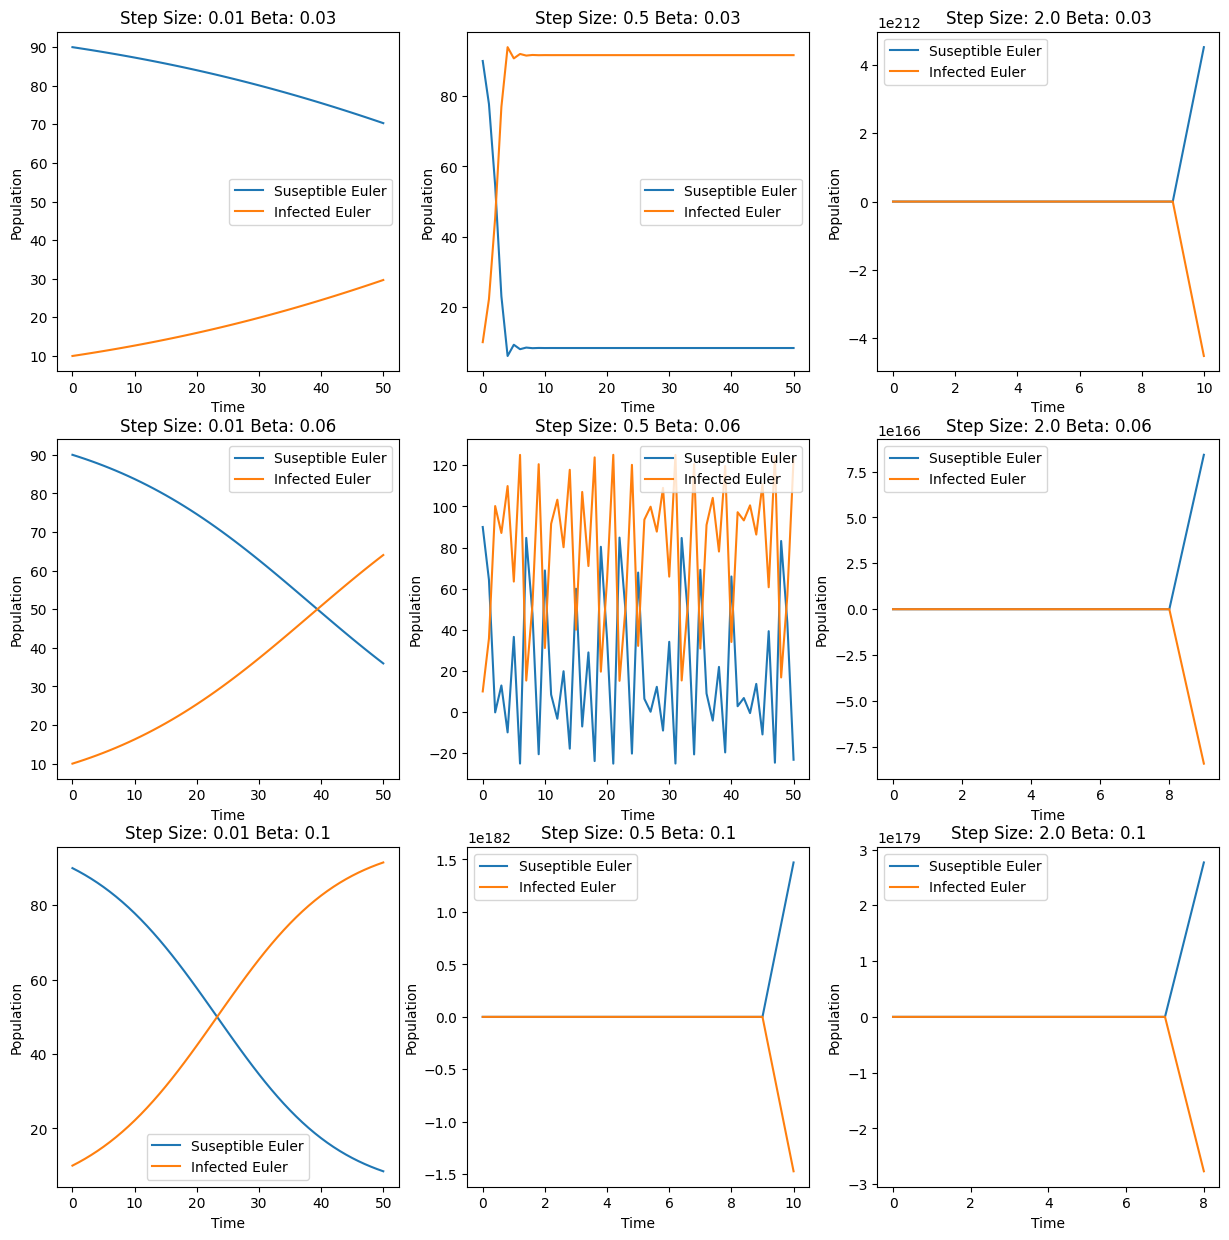

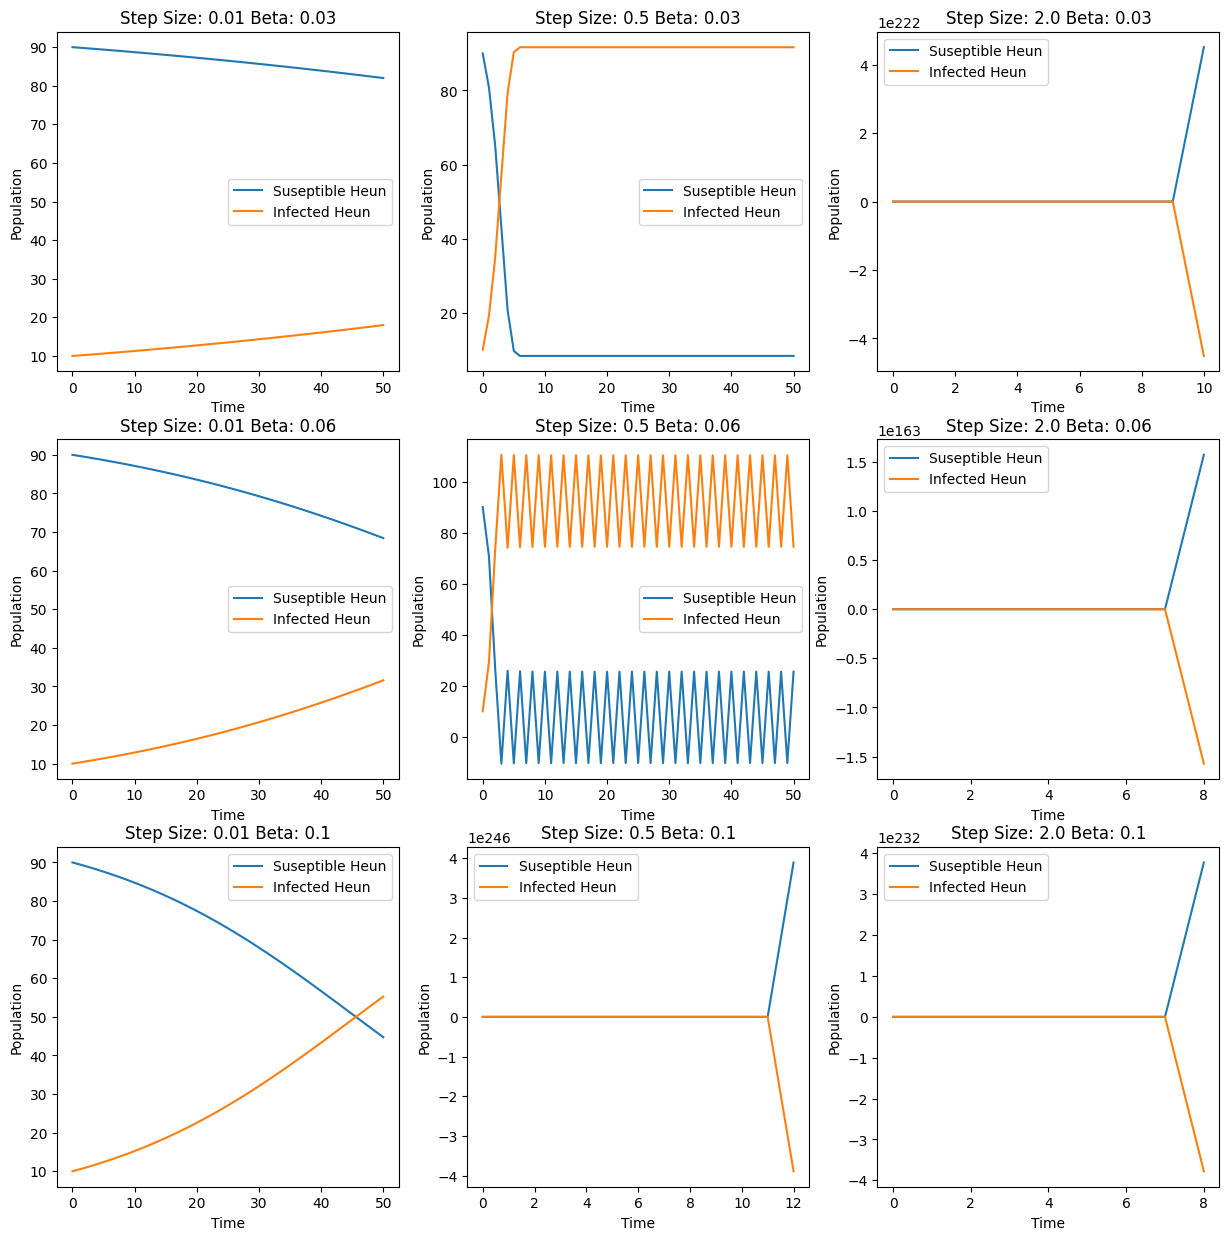

In [67]:
fig,ax = plt.subplots(3,3, figsize=(15,15))
for i, beta in enumerate(betas):
  for j, step_size in enumerate(step_sizes):
    ax[i,j].plot(numerical_sis_euler(gamma, beta, 50, step_size)[0], label="Suseptible Euler")
    ax[i,j].plot(numerical_sis_euler(gamma, beta, 50, step_size)[1], label="Infected Euler")
    ax[i,j].set_xlabel("Time")
    ax[i,j].set_ylabel("Population")
    ax[i,j].set_title(f"Step Size: {step_size} Beta: {beta}")
    ax[i,j].legend()
plt.show()

fig,ax = plt.subplots(3,3, figsize=(15,15))
for i, beta in enumerate(betas):
  for j, step_size in enumerate(step_sizes):
    ax[i,j].plot(numerical_sis_heun(gamma, beta, 50, step_size)[0], label="Suseptible Heun")
    ax[i,j].plot(numerical_sis_heun(gamma, beta, 50, step_size)[1], label="Infected Heun")
    ax[i,j].set_xlabel("Time")
    ax[i,j].set_ylabel("Population")
    ax[i,j].set_title(f"Step Size: {step_size} Beta: {beta}")
    ax[i,j].legend()
plt.show()

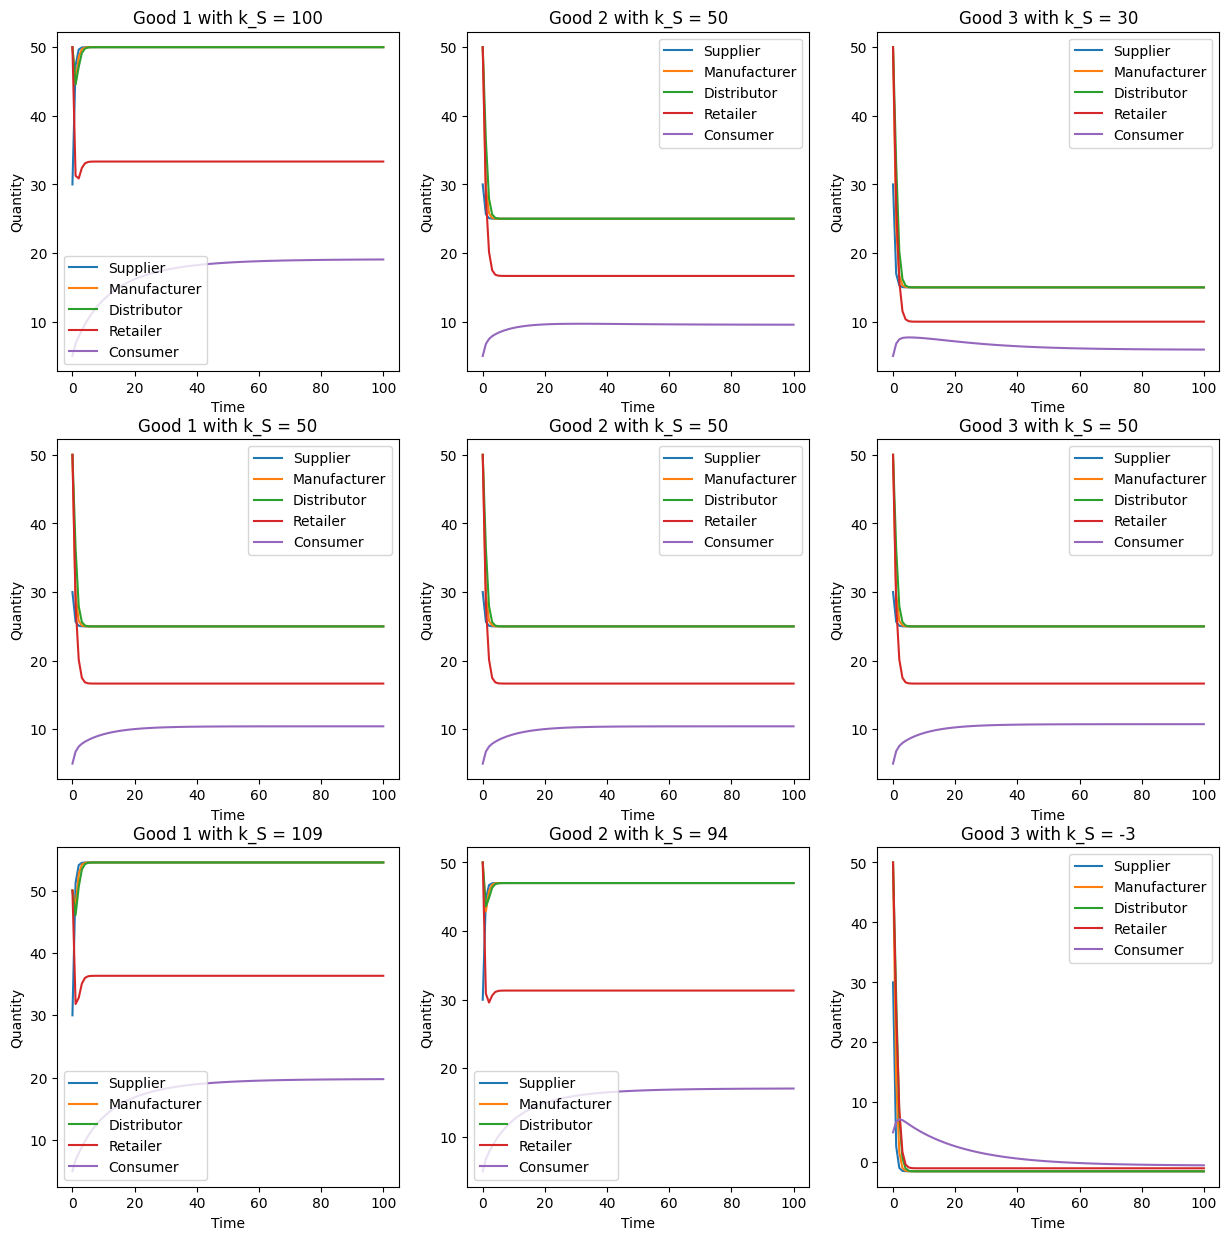

In [77]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
''' 
Supply Chain Model
'''

# Define the system of ODEs
def supply_chain(Y, t, K_p, k_SM, k_MD, k_DR, k_RC, k_CC, A, P):
    n = len(k_SM)
    # Suppliers, Manufacturers, Distributors, Retailers, Consumers
    S = np.array(Y[:n])
    M = np.array(Y[n:2*n])
    D = np.array(Y[2*n:3*n])
    R = np.array(Y[3*n:4*n])
    C = np.array(Y[4*n:])
    # Derivatives between states
    dSdt = K_p - A @ k_SM * S
    dMdt = A @ k_SM * S - k_MD * M
    dDdt = A @ k_MD * M - k_DR * D
    dRdt = A @ k_DR * D - k_RC * R
    dCdt = A @ k_RC * R * P / np.sum(Y[4*n:]) - k_CC * C
    
    return np.concatenate([dSdt, dMdt, dDdt, dRdt, dCdt])

# Define time span
tmax = 100
t = np.linspace(0, tmax, tmax)

# Initial conditions (for a 3-goods example)
S0 = np.array([30, 30, 30])
M0 = np.array([50, 50, 50])
D0 = np.array([50, 50, 50])
R0 = np.array([50, 50, 50])
C0 = np.array([5, 5, 5])
Y0 = np.concatenate([S0, M0, D0, R0, C0])

# Example parameter values
k_S = np.array([2, 2, 2])
k_SM = np.array([2, 2, 2])
k_MD = np.array([2, 2, 2])
k_DR = np.array([2, 2, 2])
k_RC = np.array([3, 3, 3])
k_CC = np.array([0.05, 0.05, 0.05]) # customer consumption, aka consumption rate of good

# Dependency matrix of Goods on each others supply chains
A = np.array([[0.8, 0.1, 0.1], [0.1, 0.8, 0.1], [0.1, 0.1, 0.8]])
# Preference vector
P = np.array([0.33, 0.33, 0.34])

# Parameter sweep (example: varying k_SM)
k_S_values = [np.array([100, 50, 30]),
              np.array([50, 50, 50]),
              np.array([round(np.random.normal(80, 40)) for _ in range(3)])]
results = []

for k in range(len(k_S_values)):
    result = odeint(supply_chain, Y0, t, args=(k_S_values[k], k_SM, k_MD, k_DR, k_RC, k_CC, A, P,))
    results.append(result)

# for each k_S value, plot the supply chain dynamics for each good with every agents values
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i in range(len(k_S_values)):
  for j in range(3):
    ax[i,j].plot(t, results[i][:, j], label="Supplier")
    ax[i,j].plot(t, results[i][:, j+3], label="Manufacturer")
    ax[i,j].plot(t, results[i][:, j+6], label="Distributor")
    ax[i,j].plot(t, results[i][:, j+9], label="Retailer")
    ax[i,j].plot(t, results[i][:, j+12], label="Consumer")
    ax[i,j].set_xlabel("Time")
    ax[i,j].set_ylabel("Quantity")
    ax[i,j].set_title(f"Good {j+1} with k_S = {k_S_values[i][j]}")
    ax[i,j].legend()
plt.show()

99
99
99
99
99
99
99
99
99


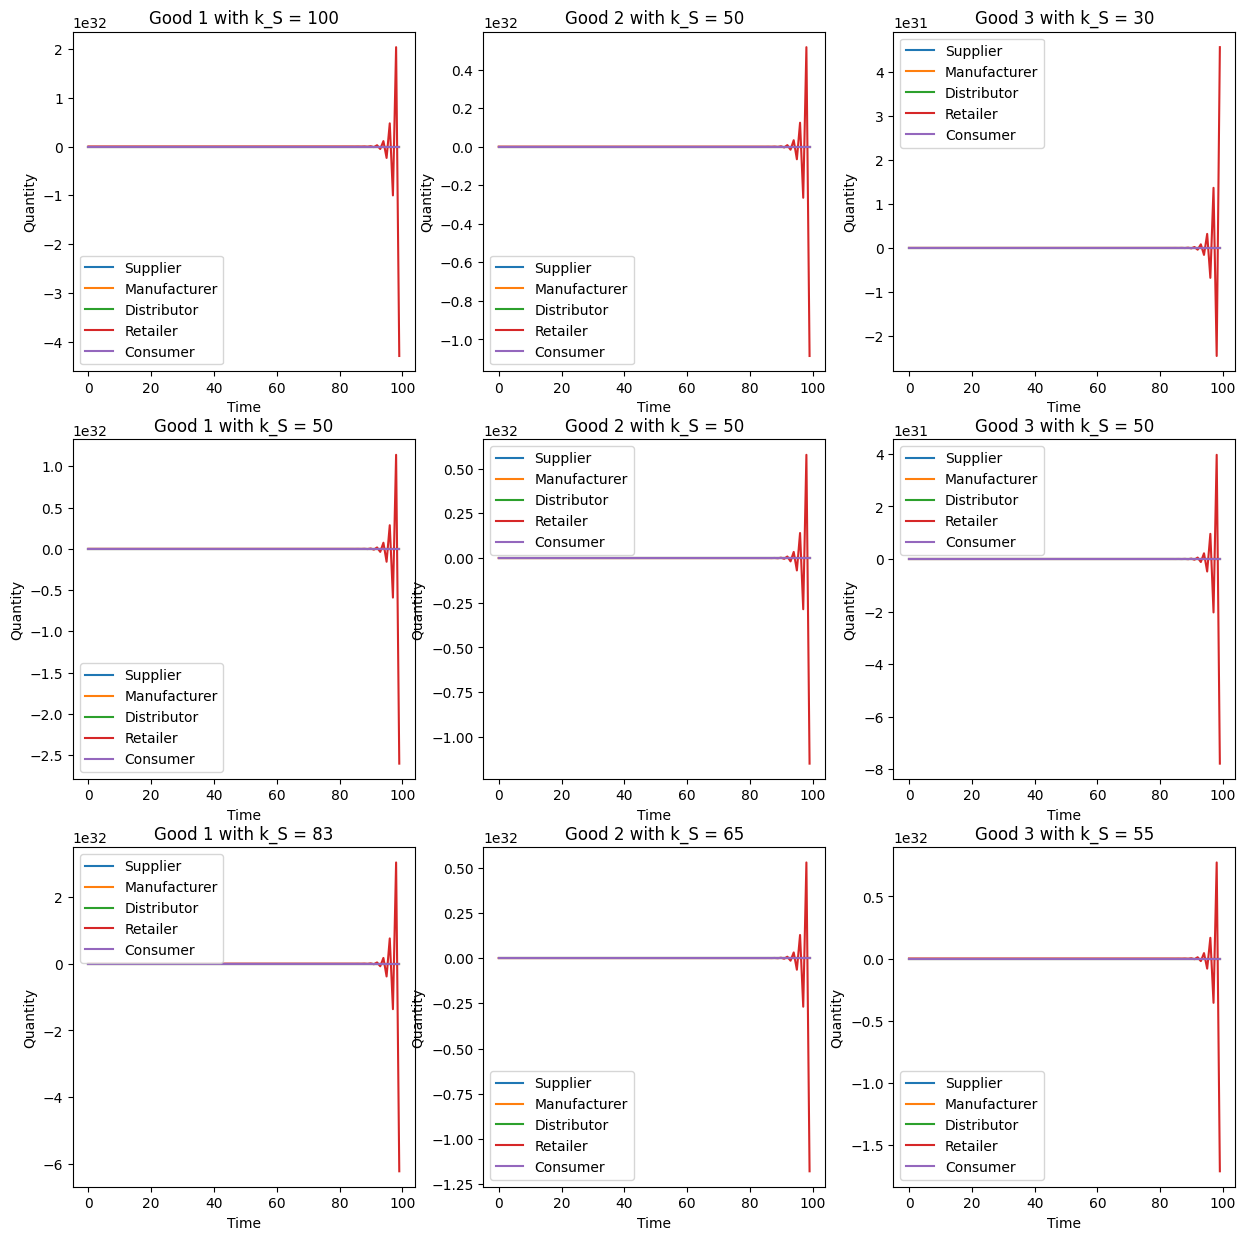

In [87]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sdeint import itoint
''' 
Supply Chain Model
'''

def supply_chain(Y, dt, K_p, k_SM, k_MD, k_DR, k_RC, k_CC, A, P, sigma):
    n = len(k_SM)
    S = np.array(Y[:n])
    M = np.array(Y[n:2*n])
    D = np.array(Y[2*n:3*n])
    R = np.array(Y[3*n:4*n])
    C = np.array(Y[4*n:])
    
    dSdt = K_p - A @ k_SM * S
    dMdt = A @ k_SM * S - k_MD * M
    dDdt = A @ k_MD * M - k_DR * D
    dRdt = A @ k_DR * D - k_RC * R
    dCdt = A @ k_RC * R * P / np.sum(Y[4*n:]) - k_CC * C
    
    # Adding unpredictability
    dSdt += sigma * np.random.normal(0, 1, n) * S
    dMdt += sigma * np.random.normal(0, 1, n) * M
    dDdt += sigma * np.random.normal(0, 1, n) * D
    dRdt += sigma * np.random.normal(0, 1, n) * R
    dCdt += sigma * np.random.normal(0, 1, n) * C
    
    Y_new = Y + np.concatenate([dSdt, dMdt, dDdt, dRdt, dCdt]) * dt
    
    return Y_new

# Define time span
tmax = 100
t = np.linspace(0, tmax, tmax)

# Initial conditions (for a 3-goods example)
S0 = np.array([30, 30, 30])
M0 = np.array([50, 50, 50])
D0 = np.array([50, 50, 50])
R0 = np.array([50, 50, 50])
C0 = np.array([5, 5, 5])
Y0 = np.concatenate([S0, M0, D0, R0, C0])

# Example parameter values
k_S = np.array([2, 2, 2])
k_SM = np.array([2, 2, 2])
k_MD = np.array([2, 2, 2])
k_DR = np.array([2, 2, 2])
k_RC = np.array([3, 3, 3])
k_CC = np.array([0.05, 0.05, 0.05]) # customer consumption, aka consumption rate of good

# Dependency matrix of Goods on each others supply chains
A = np.array([[0.8, 0.1, 0.1], [0.1, 0.8, 0.1], [0.1, 0.1, 0.8]])
# Preference vector
P = np.array([0.33, 0.33, 0.34])

# Parameter sweep (example: varying k_SM)
k_S_values = [np.array([100, 50, 30]),
              np.array([50, 50, 50]),
              np.array([round(np.random.normal(80, 40)) for _ in range(3)])]
results = []

for k in range(len(k_S_values)):
    Y = Y0.copy()
    result = []
    for i in range(len(t)-1):
        Y = supply_chain(Y, t[i+1]-t[i], k_S_values[k], k_SM, k_MD, k_DR, k_RC, k_CC, A, P, 0.1)
        result.append(Y)
    results.append(np.array(result))

# for each k_S value, plot the supply chain dynamics for each good with every agents values
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i in range(len(k_S_values)):
  for j in range(3):
    print(len(results[i][:, j]))
    ax[i,j].plot(t[:tmax-1], results[i][:, j], label="Supplier")
    ax[i,j].plot(t[:tmax-1], results[i][:, j+3], label="Manufacturer")
    ax[i,j].plot(t[:tmax-1], results[i][:, j+6], label="Distributor")
    ax[i,j].plot(t[:tmax-1], results[i][:, j+9], label="Retailer")
    ax[i,j].plot(t[:tmax-1], results[i][:, j+12], label="Consumer")
    ax[i,j].set_xlabel("Time")
    ax[i,j].set_ylabel("Quantity")
    ax[i,j].set_title(f"Good {j+1} with k_S = {k_S_values[i][j]}")
    ax[i,j].legend()
plt.show()